# Environment

In [1]:
import gym
import tensorflow as tf
from tensorflow import keras
import random
import numpy as np
import datetime as dt
import math

import matplotlib.pyplot as plt
from gridworld import SimpleGrid


class custom_env:

    def __init__(self, env_name, param={}):
        # Initialize atributes
        self.env_name = env_name    # name of environment
        self.param = param          # dictionarry of environment parameters

        if (self.env_name == "SimpleGrid"):
            self.env = SimpleGrid(self.param["grid_size"],
                                  block_pattern=self.param["pattern"],
                                  obs_mode=self.param["obs_mode"])

            self.action_space = gym.spaces.Discrete(4)
            self.env.reset(
                agent_pos=self.param["agent_pos"], goal_pos=self.param["goal_pos"])

            self.state_type = "Discrete"
            self.observation_space = gym.spaces.Discrete(
                self.param["grid_size"]**2)
            
            print("self.env", self.env)

        if (self.env_name.split("_")[0] == "gym"):
            gym_name = "_".join(self.env_name.split("_")[1:])
            self.env = gym.make(gym_name)
            self.action_space = self.env.action_space
            if (type(self.env.observation_space) == gym.spaces.discrete.Discrete):
                self.observation_space = self.env.observation_space
                self.state_type = "Discrete"
            else:
                self.state_type = "Continue"

        observation = self.reset()
        if self.state_type == "Discrete":
            self.state_dim = 1
        else:
            self.state_dim = len(observation)

    def reset(self):
        
        return_reset = self.env.reset()
        
        if (self.env_name == "SimpleGrid"):
            self.env.reset(agent_pos=self.param["agent_pos"], goal_pos=self.param["goal_pos"])
            return_reset = self.env.observation        
        
        if self.state_type == "Discrete":
            return_reset = np.array([return_reset])        
        
        return return_reset

    def render(self):
        if (self.env_name == "SimpleGrid"):
            
            fig = plt.figure(figsize=(5, 5))         
            plt.imshow(self.env.grid)
            plt.show()
        if (self.env_name.split("_")[0] == "gym"):
            self.env.render()

    def step(self, action):
        if (self.env_name == "SimpleGrid"):
            reward = self.env.step(action)
            next_state = self.env.observation
            done = self.env.done
            info = ""
            return np.array([next_state]), reward, done, info

        if self.state_type == "Discrete":
            next_state, reward, done, info = self.env.step(action)
            return np.array([next_state]), reward, done, info
        else:
            return self.env.step(action)

    def close(self):
        if (self.env_name.split("_")[0] == "gym"):
            self.env.close()


# Agent

In [2]:
class Agent:
    def __init__(self, enviroment, param={}):

        self.param = param
        self._action_size = enviroment.action_space.n
        self.state_dim = env.state_dim

        if enviroment.state_type == "Discrete":
            self._state_size = enviroment.observation_space.n

            self.primary_network = keras.Sequential([
                keras.layers.Embedding(self._state_size, 10, input_length=1),
                keras.layers.Reshape((10,)),
                keras.layers.Dense(30, activation='relu'),
                keras.layers.Dense(30, activation='relu'),
                keras.layers.Dense(self._action_size)
            ])

            self.target_network = keras.Sequential([
                keras.layers.Embedding(self._state_size, 10, input_length=1),
                keras.layers.Reshape((10,)),
                keras.layers.Dense(30, activation='relu'),
                keras.layers.Dense(30, activation='relu'),
                keras.layers.Dense(self._action_size)
            ])

            self.primary_network.compile(
                optimizer=self.param["optimizer"], loss='mse')

        if enviroment.state_type == "Continue":
            self.primary_network = keras.Sequential([
                keras.layers.Dense(
                    30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
                keras.layers.Dense(
                    30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
                keras.layers.Dense(self._action_size)
            ])

            self.target_network = keras.Sequential([
                keras.layers.Dense(
                    30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
                keras.layers.Dense(
                    30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
                keras.layers.Dense(self._action_size)
            ])

            self.primary_network.compile(
                optimizer=self.param["optimizer"], loss='mse')

         # Initialize policy
        if (param_agent["policy"]["type"][0] == "eps-greedy"):
            self.policy = "eps-greedy"

            if (param_agent["policy"]["type"][1] == "exponantial"):
                self.pi_1 = "exponantial"

                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_max = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_min = self.param["policy"][self.policy][self.pi_1]["eps_min"]
                self._lambda = self.param["policy"][self.policy][self.pi_1]["lambda"]

            if (param_agent["policy"]["type"][1] == "constant"):
                self.pi_1 = "constant"
                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps"]

    def choose_action(self, state, primary_network, steps):
        if (self.policy == "eps-greedy"):
            if (self.pi_1 == "exponantial"):
                self.epsilon = self.eps_min + \
                    (self.eps_max - self.eps_min) * \
                    math.exp(-self._lambda * steps)

            if random.random() < self.epsilon:
                return random.randint(0, self._action_size - 1), self.epsilon
            else:
                return np.argmax(primary_network(state.reshape(1, -1))), self.epsilon

    def train(self, primary_network, memory, target_network=None):
        if memory.num_samples < BATCH_SIZE * 3:
            return 0
        batch = memory.sample(BATCH_SIZE)
        states = np.array([val[0] for val in batch])

        actions = np.array([val[1] for val in batch])
        rewards = np.array([val[2] for val in batch])
        next_states = np.array([(np.zeros(self.state_dim)
                                 if val[3] is None else val[3]) for val in batch])

        prim_qt = primary_network(states)
        prim_qtp1 = primary_network(next_states)

        # copy the prim_qt tensor into the target_q tensor - 
#         we then will update one index corresponding to the max action
        target_q = prim_qt.numpy()

        updates = rewards.astype(np.float32)

        valid_idxs = np.array(next_states).sum(axis=1) != 0

        batch_idxs = np.arange(BATCH_SIZE)


        if target_network is None:
            updates[valid_idxs] += self.param["gamma"] * \
                np.amax(prim_qtp1.numpy()[valid_idxs, :], axis=1)
        else:

            prim_action_tp1 = np.argmax(prim_qtp1.numpy(), axis=1)
            q_from_target = target_network(next_states)

            updates[valid_idxs] += self.param["gamma"] * q_from_target.numpy()[
                batch_idxs[valid_idxs],
                prim_action_tp1[valid_idxs]]
            
            

        target_q[batch_idxs, actions] = updates
        loss = primary_network.train_on_batch(states, target_q)

        if target_network is not None:
            # update target network parameters slowly from primary network
            for t, e in zip(target_network.trainable_variables, primary_network.trainable_variables):
                t.assign(t * (1 - self.param["tau"]) + e * self.param["tau"])

        return loss



# Storage

In [3]:

class Memory:
    def __init__(self, max_memory):
        self._max_memory = max_memory
        self._samples = []

    def add_sample(self, sample):
        self._samples.append(sample)
        if len(self._samples) > self._max_memory:
            self._samples.pop(0)

    def sample(self, no_samples):
        if no_samples > len(self._samples):
            return random.sample(self._samples, len(self._samples))
        else:
            return random.sample(self._samples, no_samples)

    @property
    def num_samples(self):
        return len(self._samples)


# Parameters

In [4]:

param_env = {
    "agent_pos":None, 
    "goal_pos":[0, 7-1],
    "grid_size" : 7,
    "pattern":"random",
    "obs_mode":"index",
}
env_name = "SimpleGrid"
# env_name = "gym_CartPole-v1"

env = custom_env(env_name, param_env)
    
STORE_PATH = '.'

BATCH_SIZE = 32
RANDOM_REWARD_STD = -1.0

param_agent = {
    "optimizer": keras.optimizers.Adam(),
    "policy": {
        "type": ["eps-greedy", "exponantial"],
        "eps-greedy": {
            "exponantial": {
                "eps_max": 1.,
                "eps_min": 0.01,
                "lambda": 0.0005
            },
            "constant": {
                "eps": 0.01
            }
        }
    },
    "gamma": 0.95,
    "tau": 0.08,
}


memory = Memory(500000)

agent = Agent(env, param_agent)

num_episodes = 1000
render = False
train_writer = tf.summary.create_file_writer(
    STORE_PATH + f"/DoubleQ_{dt.datetime.now().strftime('%d%m%Y%H%M')}")
double_q = True
steps = 0


self.env <gridworld.SimpleGrid object at 0x7f90d067f3d0>


# Run

In [5]:
for i in range(num_episodes):
    state = env.reset()

    reward_sum = 0
    cnt = 0
    avg_loss = 0
    while True:
        if render:
            env.render()

        action, eps = agent.choose_action(state, agent.primary_network, steps)
        next_state, reward, done, info = env.step(action)

        if RANDOM_REWARD_STD > 0:
            reward = np.random.normal(1.0, RANDOM_REWARD_STD)

            
#         print("state: ", state)
#         print("action : ", action)
#         print("reward: ", reward)
#         print("next_state : ", next_state)
#         print("done : ",  done)
#         print("-------------------- \n")
            
        reward_sum+= reward
        if done:
            next_state = None
        # store in memory
        memory.add_sample((state, action, reward, next_state))

        loss = agent.train(agent.primary_network, memory,
                           agent.target_network if double_q else None)
        avg_loss += loss

        state = next_state

        # exponentially decay the eps value
        steps += 1
#         eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * steps)

        if done:
            if cnt != 0 : avg_loss /= cnt
            else : avg_loss = 0
            print(
                f"Episode: {i}, step: {cnt}, Reward: {reward_sum}, avg loss: {avg_loss:.4f}, eps: {eps:.3f}")
            with train_writer.as_default():
                tf.summary.scalar('reward', cnt, step=i)
                tf.summary.scalar('avg loss', avg_loss, step=i)
            break

        cnt += 1

Episode: 0, step: 0, Reward: 1.0, avg loss: 0.0000, eps: 1.000
Episode: 1, step: 105, Reward: 1.0, avg loss: 0.0002, eps: 0.949
Episode: 2, step: 85, Reward: 1.0, avg loss: 0.0031, eps: 0.909
Episode: 3, step: 132, Reward: 1.0, avg loss: 0.0014, eps: 0.852
Episode: 4, step: 1, Reward: 1.0, avg loss: 0.0022, eps: 0.851
Episode: 5, step: 58, Reward: 1.0, avg loss: 0.0014, eps: 0.826
Episode: 6, step: 41, Reward: 1.0, avg loss: 0.0008, eps: 0.809
Episode: 7, step: 11, Reward: 1.0, avg loss: 0.0006, eps: 0.804
Episode: 8, step: 27, Reward: 1.0, avg loss: 0.0004, eps: 0.793
Episode: 9, step: 57, Reward: 1.0, avg loss: 0.0002, eps: 0.771
Episode: 10, step: 89, Reward: 1.0, avg loss: 0.0001, eps: 0.738
Episode: 11, step: 63, Reward: 1.0, avg loss: 0.0001, eps: 0.715
Episode: 12, step: 39, Reward: 1.0, avg loss: 0.0001, eps: 0.701
Episode: 13, step: 34, Reward: 1.0, avg loss: 0.0001, eps: 0.689
Episode: 14, step: 4, Reward: 1.0, avg loss: 0.0002, eps: 0.687
Episode: 15, step: 37, Reward: 1.0, 

Episode: 127, step: 7, Reward: 1.0, avg loss: 0.0000, eps: 0.344
Episode: 128, step: 5, Reward: 1.0, avg loss: 0.0000, eps: 0.343
Episode: 129, step: 0, Reward: 1.0, avg loss: 0.0000, eps: 0.343
Episode: 130, step: 7, Reward: 1.0, avg loss: 0.0000, eps: 0.342
Episode: 131, step: 3, Reward: 1.0, avg loss: 0.0000, eps: 0.341
Episode: 132, step: 3, Reward: 1.0, avg loss: 0.0000, eps: 0.340
Episode: 133, step: 8, Reward: 1.0, avg loss: 0.0000, eps: 0.339
Episode: 134, step: 4, Reward: 1.0, avg loss: 0.0000, eps: 0.338
Episode: 135, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.337
Episode: 136, step: 9, Reward: 1.0, avg loss: 0.0000, eps: 0.335
Episode: 137, step: 21, Reward: 1.0, avg loss: 0.0000, eps: 0.332
Episode: 138, step: 5, Reward: 1.0, avg loss: 0.0000, eps: 0.331
Episode: 139, step: 4, Reward: 1.0, avg loss: 0.0000, eps: 0.330
Episode: 140, step: 5, Reward: 1.0, avg loss: 0.0000, eps: 0.329
Episode: 141, step: 5, Reward: 1.0, avg loss: 0.0000, eps: 0.328
Episode: 142, step: 26, 

Episode: 256, step: 7, Reward: 1.0, avg loss: 0.0000, eps: 0.199
Episode: 257, step: 12, Reward: 1.0, avg loss: 0.0000, eps: 0.198
Episode: 258, step: 10, Reward: 1.0, avg loss: 0.0000, eps: 0.197
Episode: 259, step: 3, Reward: 1.0, avg loss: 0.0000, eps: 0.197
Episode: 260, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.196
Episode: 261, step: 12, Reward: 1.0, avg loss: 0.0000, eps: 0.195
Episode: 262, step: 5, Reward: 1.0, avg loss: 0.0000, eps: 0.194
Episode: 263, step: 9, Reward: 1.0, avg loss: 0.0000, eps: 0.193
Episode: 264, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.193
Episode: 265, step: 2, Reward: 1.0, avg loss: 0.0000, eps: 0.192
Episode: 266, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.192
Episode: 267, step: 10, Reward: 1.0, avg loss: 0.0000, eps: 0.191
Episode: 268, step: 7, Reward: 1.0, avg loss: 0.0000, eps: 0.190
Episode: 269, step: 5, Reward: 1.0, avg loss: 0.0000, eps: 0.190
Episode: 270, step: 7, Reward: 1.0, avg loss: 0.0000, eps: 0.189
Episode: 271, step: 1

Episode: 382, step: 5, Reward: 1.0, avg loss: 0.0000, eps: 0.125
Episode: 383, step: 8, Reward: 1.0, avg loss: 0.0000, eps: 0.124
Episode: 384, step: 9, Reward: 1.0, avg loss: 0.0000, eps: 0.124
Episode: 385, step: 1, Reward: 1.0, avg loss: 0.0000, eps: 0.124
Episode: 386, step: 9, Reward: 1.0, avg loss: 0.0000, eps: 0.123
Episode: 387, step: 12, Reward: 1.0, avg loss: 0.0000, eps: 0.122
Episode: 388, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.122
Episode: 389, step: 4, Reward: 1.0, avg loss: 0.0000, eps: 0.122
Episode: 390, step: 2, Reward: 1.0, avg loss: 0.0000, eps: 0.121
Episode: 391, step: 7, Reward: 1.0, avg loss: 0.0000, eps: 0.121
Episode: 392, step: 9, Reward: 1.0, avg loss: 0.0000, eps: 0.120
Episode: 393, step: 10, Reward: 1.0, avg loss: 0.0000, eps: 0.120
Episode: 394, step: 11, Reward: 1.0, avg loss: 0.0000, eps: 0.119
Episode: 395, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.119
Episode: 396, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.118
Episode: 397, step: 5,

Episode: 508, step: 4, Reward: 1.0, avg loss: 0.0000, eps: 0.084
Episode: 509, step: 8, Reward: 1.0, avg loss: 0.0000, eps: 0.084
Episode: 510, step: 11, Reward: 1.0, avg loss: 0.0000, eps: 0.084
Episode: 511, step: 9, Reward: 1.0, avg loss: 0.0000, eps: 0.083
Episode: 512, step: 7, Reward: 1.0, avg loss: 0.0000, eps: 0.083
Episode: 513, step: 2, Reward: 1.0, avg loss: 0.0000, eps: 0.083
Episode: 514, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.083
Episode: 515, step: 14, Reward: 1.0, avg loss: 0.0000, eps: 0.082
Episode: 516, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.082
Episode: 517, step: 8, Reward: 1.0, avg loss: 0.0000, eps: 0.082
Episode: 518, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.081
Episode: 519, step: 4, Reward: 1.0, avg loss: 0.0000, eps: 0.081
Episode: 520, step: 3, Reward: 1.0, avg loss: 0.0000, eps: 0.081
Episode: 521, step: 2, Reward: 1.0, avg loss: 0.0000, eps: 0.081
Episode: 522, step: 3, Reward: 1.0, avg loss: 0.0000, eps: 0.081
Episode: 523, step: 2, 

Episode: 636, step: 8, Reward: 1.0, avg loss: 0.0000, eps: 0.058
Episode: 637, step: 5, Reward: 1.0, avg loss: 0.0000, eps: 0.058
Episode: 638, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.058
Episode: 639, step: 10, Reward: 1.0, avg loss: 0.0000, eps: 0.057
Episode: 640, step: 4, Reward: 1.0, avg loss: 0.0000, eps: 0.057
Episode: 641, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.057
Episode: 642, step: 11, Reward: 1.0, avg loss: 0.0000, eps: 0.057
Episode: 643, step: 4, Reward: 1.0, avg loss: 0.0000, eps: 0.057
Episode: 644, step: 7, Reward: 1.0, avg loss: 0.0000, eps: 0.057
Episode: 645, step: 5, Reward: 1.0, avg loss: 0.0000, eps: 0.056
Episode: 646, step: 7, Reward: 1.0, avg loss: 0.0000, eps: 0.056
Episode: 647, step: 2, Reward: 1.0, avg loss: 0.0000, eps: 0.056
Episode: 648, step: 7, Reward: 1.0, avg loss: 0.0000, eps: 0.056
Episode: 649, step: 9, Reward: 1.0, avg loss: 0.0000, eps: 0.056
Episode: 650, step: 8, Reward: 1.0, avg loss: 0.0000, eps: 0.056
Episode: 651, step: 4, 

Episode: 762, step: 5, Reward: 1.0, avg loss: 0.0000, eps: 0.042
Episode: 763, step: 8, Reward: 1.0, avg loss: 0.0000, eps: 0.042
Episode: 764, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.041
Episode: 765, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.041
Episode: 766, step: 3, Reward: 1.0, avg loss: 0.0000, eps: 0.041
Episode: 767, step: 2, Reward: 1.0, avg loss: 0.0000, eps: 0.041
Episode: 768, step: 9, Reward: 1.0, avg loss: 0.0000, eps: 0.041
Episode: 769, step: 10, Reward: 1.0, avg loss: 0.0000, eps: 0.041
Episode: 770, step: 4, Reward: 1.0, avg loss: 0.0000, eps: 0.041
Episode: 771, step: 8, Reward: 1.0, avg loss: 0.0000, eps: 0.041
Episode: 772, step: 3, Reward: 1.0, avg loss: 0.0000, eps: 0.041
Episode: 773, step: 3, Reward: 1.0, avg loss: 0.0000, eps: 0.041
Episode: 774, step: 8, Reward: 1.0, avg loss: 0.0000, eps: 0.040
Episode: 775, step: 3, Reward: 1.0, avg loss: 0.0000, eps: 0.040
Episode: 776, step: 7, Reward: 1.0, avg loss: 0.0000, eps: 0.040
Episode: 777, step: 10, 

Episode: 889, step: 11, Reward: 1.0, avg loss: 0.0000, eps: 0.031
Episode: 890, step: 5, Reward: 1.0, avg loss: 0.0000, eps: 0.031
Episode: 891, step: 3, Reward: 1.0, avg loss: 0.0000, eps: 0.031
Episode: 892, step: 5, Reward: 1.0, avg loss: 0.0000, eps: 0.031
Episode: 893, step: 5, Reward: 1.0, avg loss: 0.0000, eps: 0.031
Episode: 894, step: 7, Reward: 1.0, avg loss: 0.0000, eps: 0.031
Episode: 895, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.031
Episode: 896, step: 9, Reward: 1.0, avg loss: 0.0000, eps: 0.031
Episode: 897, step: 0, Reward: 1.0, avg loss: 0.0000, eps: 0.031
Episode: 898, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.031
Episode: 899, step: 5, Reward: 1.0, avg loss: 0.0000, eps: 0.031
Episode: 900, step: 9, Reward: 1.0, avg loss: 0.0000, eps: 0.031
Episode: 901, step: 6, Reward: 1.0, avg loss: 0.0000, eps: 0.030
Episode: 902, step: 11, Reward: 1.0, avg loss: 0.0000, eps: 0.030
Episode: 903, step: 1, Reward: 1.0, avg loss: 0.0000, eps: 0.030
Episode: 904, step: 6, 

In [6]:
env.state_type

'Discrete'

In [7]:
env.reset()
action = random.randint(0, env.action_space.n - 1)
action
env.step(action)



(array([15]), 0.0, False, '')

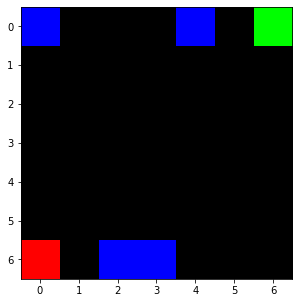

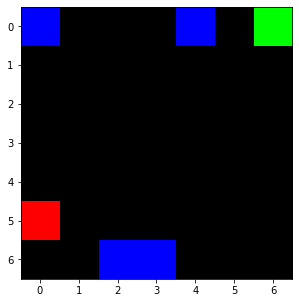

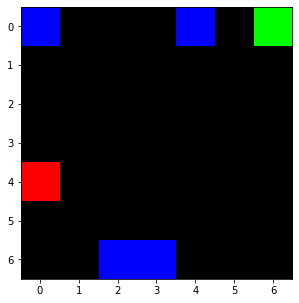

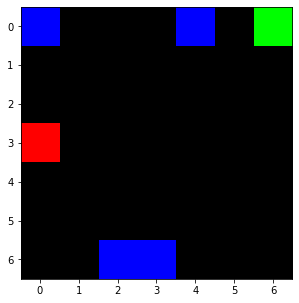

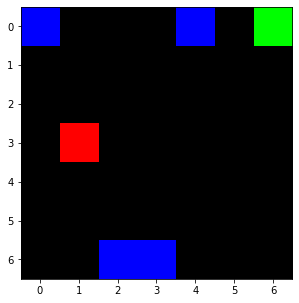

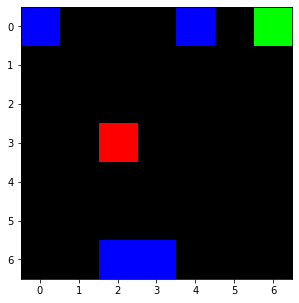

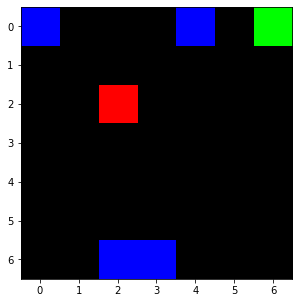

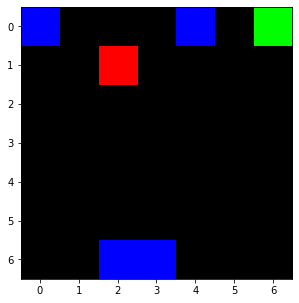

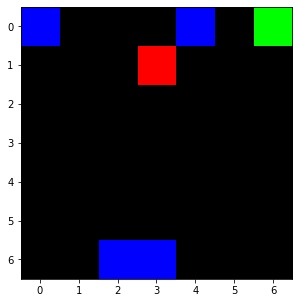

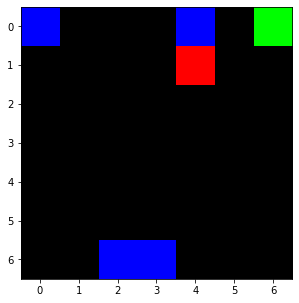

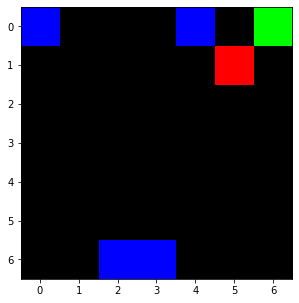

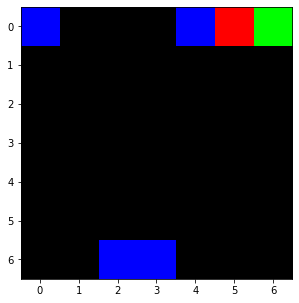

Episode: 0, step: 11, Reward: 1.0, avg loss: 0.000, eps: 0.010


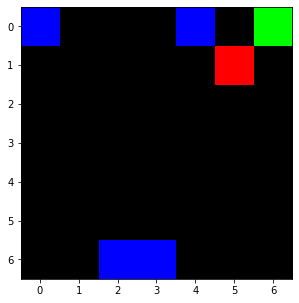

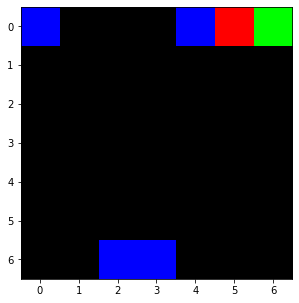

Episode: 1, step: 1, Reward: 1.0, avg loss: 0.000, eps: 0.010


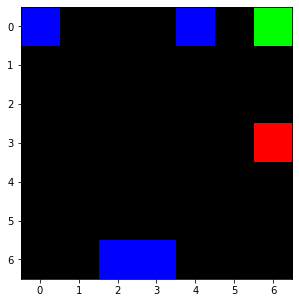

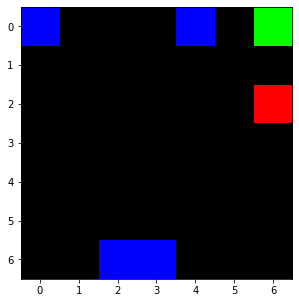

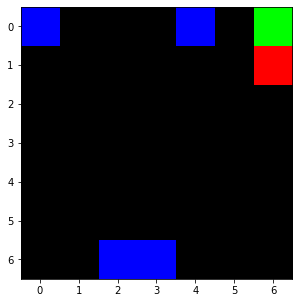

Episode: 2, step: 2, Reward: 1.0, avg loss: 0.000, eps: 0.010


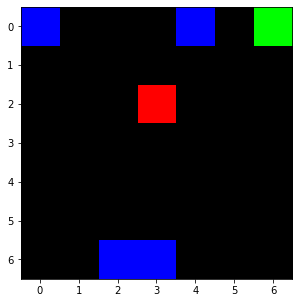

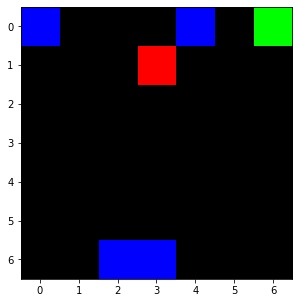

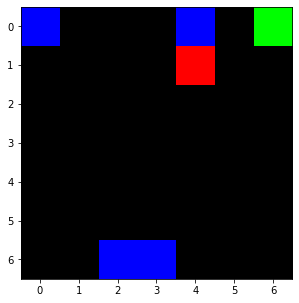

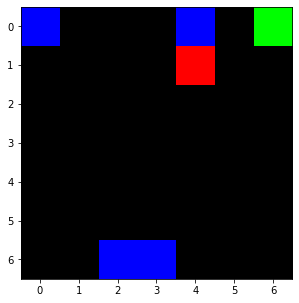

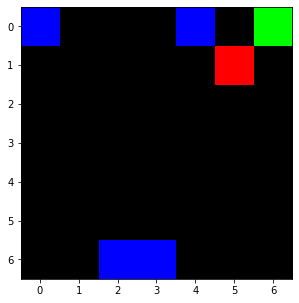

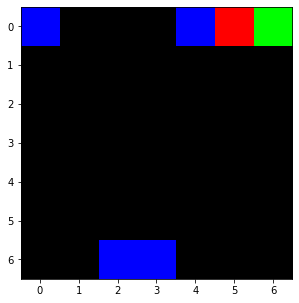

Episode: 3, step: 5, Reward: 1.0, avg loss: 0.000, eps: 0.010


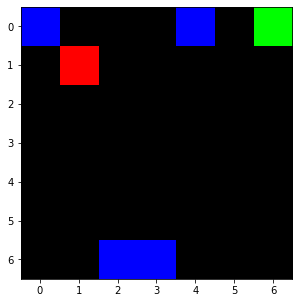

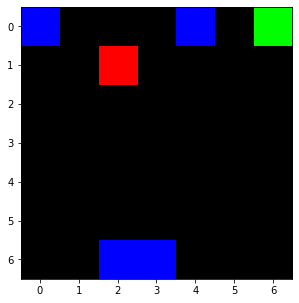

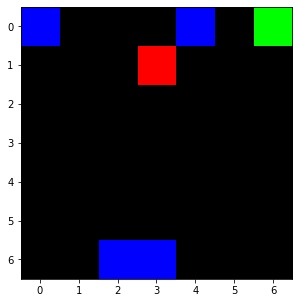

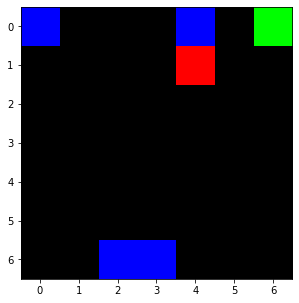

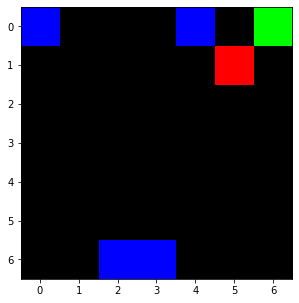

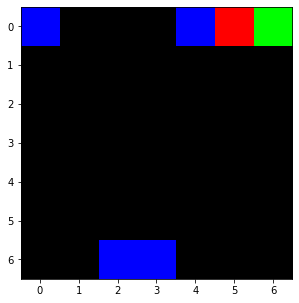

Episode: 4, step: 5, Reward: 1.0, avg loss: 0.000, eps: 0.010


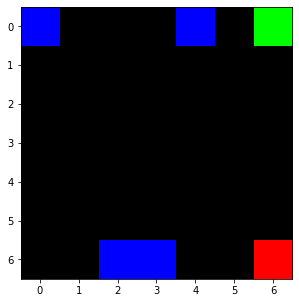

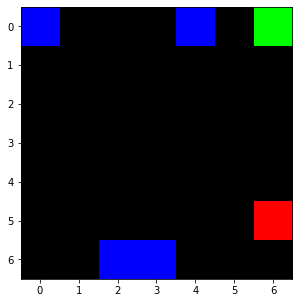

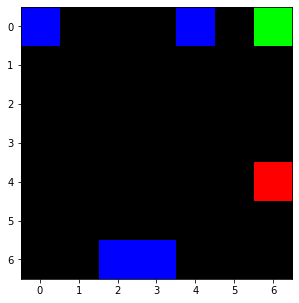

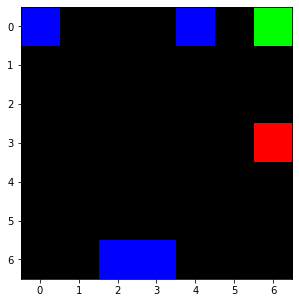

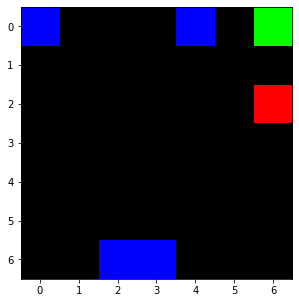

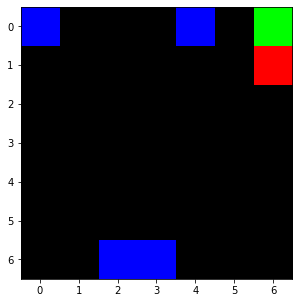

Episode: 5, step: 5, Reward: 1.0, avg loss: 0.000, eps: 0.010


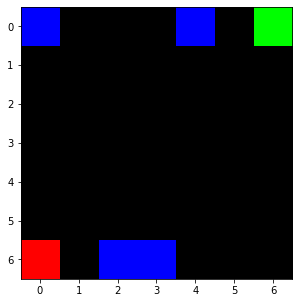

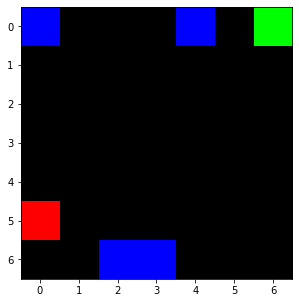

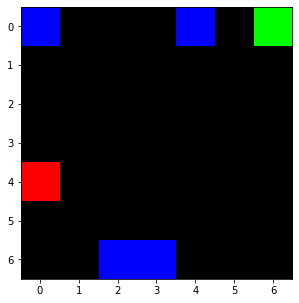

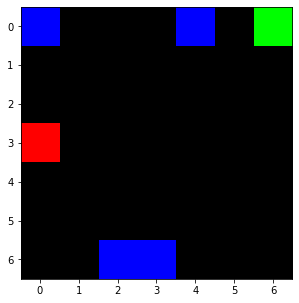

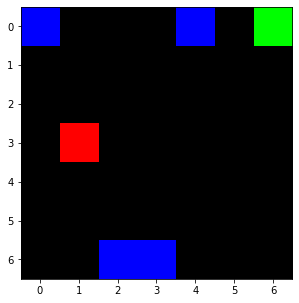

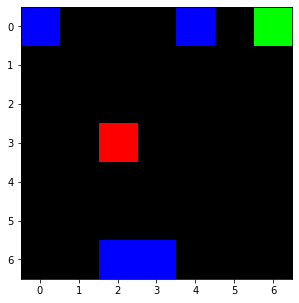

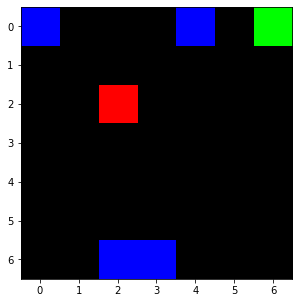

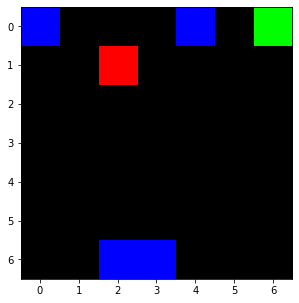

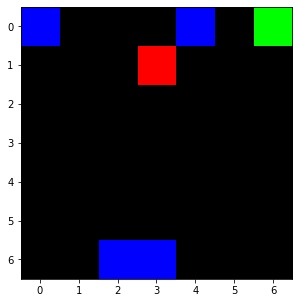

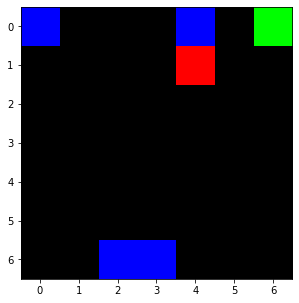

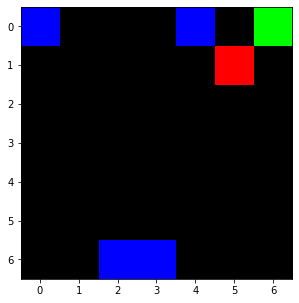

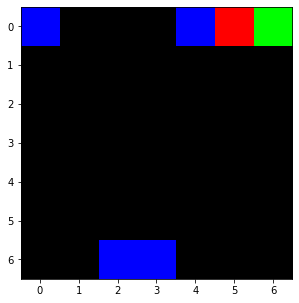

Episode: 6, step: 11, Reward: 1.0, avg loss: 0.000, eps: 0.010


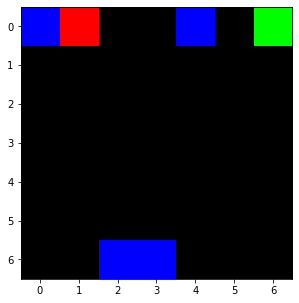

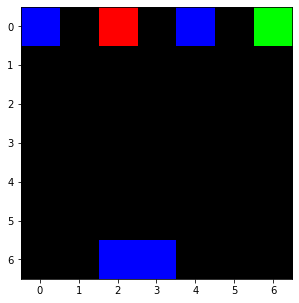

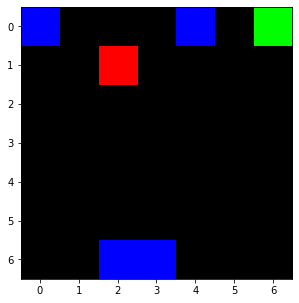

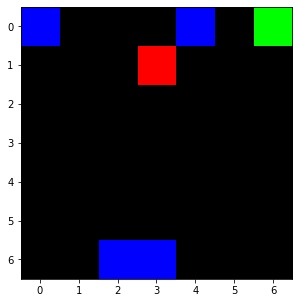

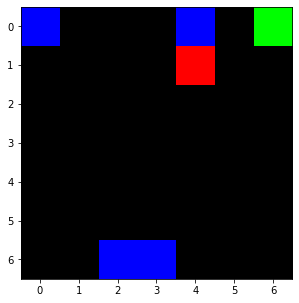

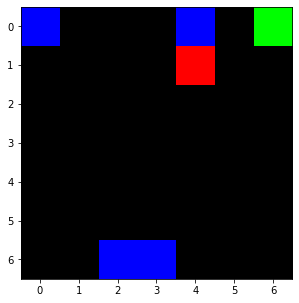

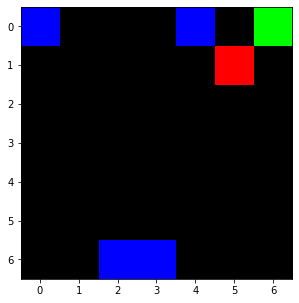

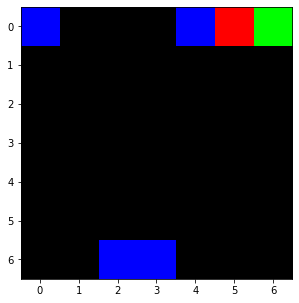

Episode: 7, step: 7, Reward: 1.0, avg loss: 0.000, eps: 0.010


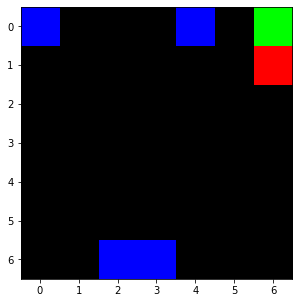

Episode: 8, step: 0, Reward: 1.0, avg loss: 0.000, eps: 0.010


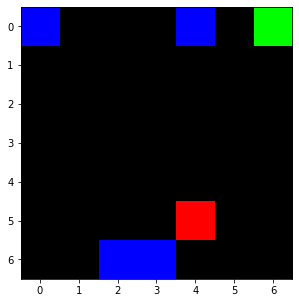

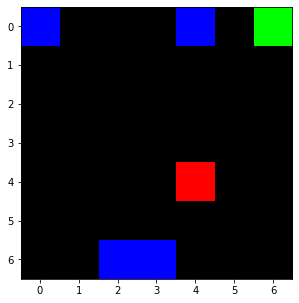

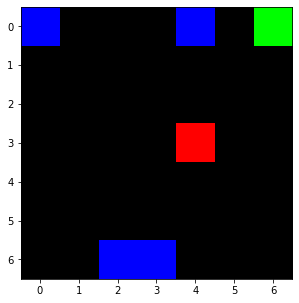

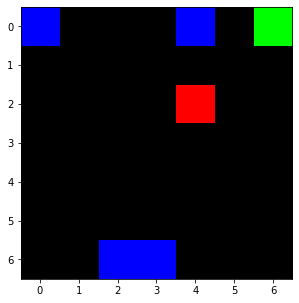

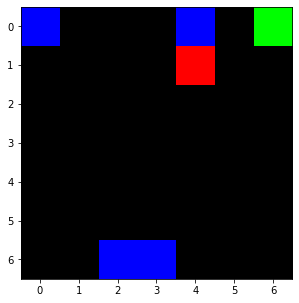

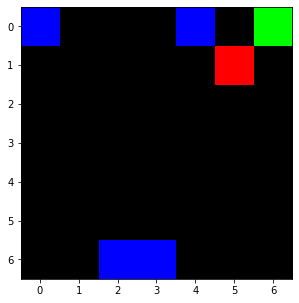

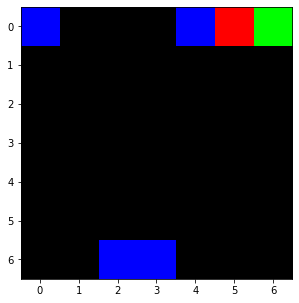

Episode: 9, step: 6, Reward: 1.0, avg loss: 0.000, eps: 0.010


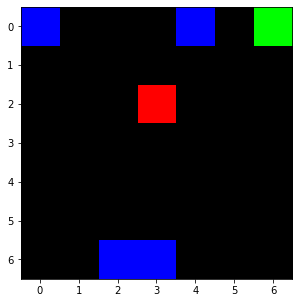

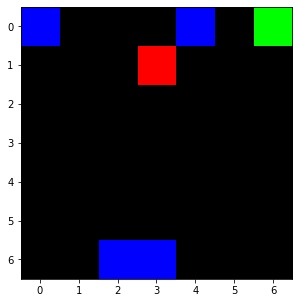

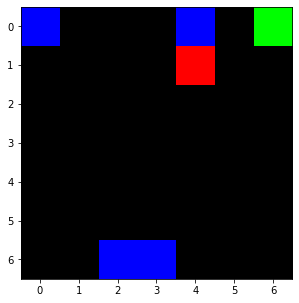

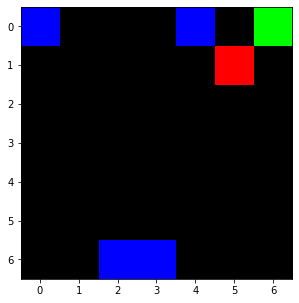

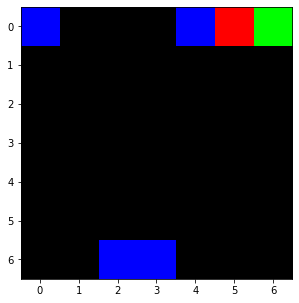

Episode: 10, step: 4, Reward: 1.0, avg loss: 0.000, eps: 0.010


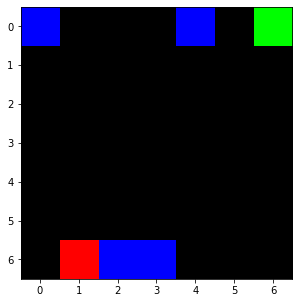

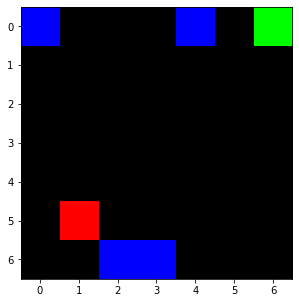

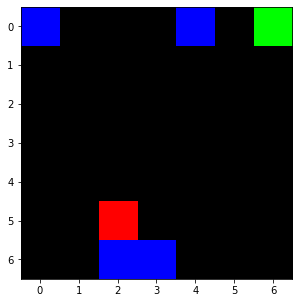

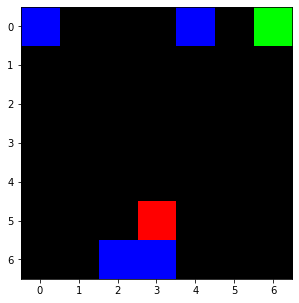

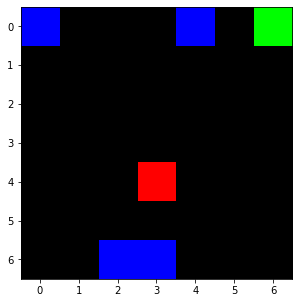

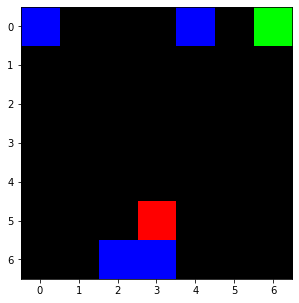

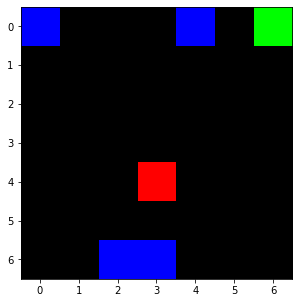

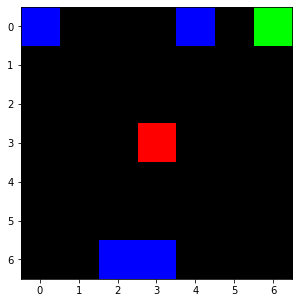

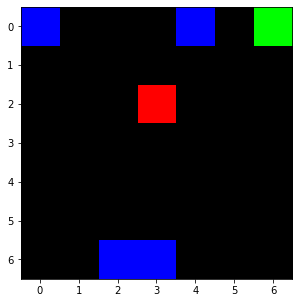

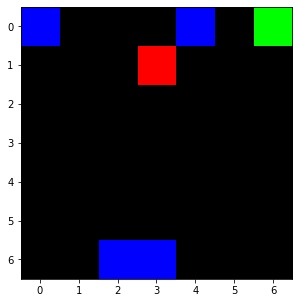

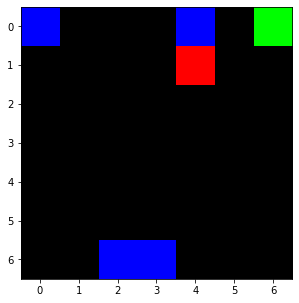

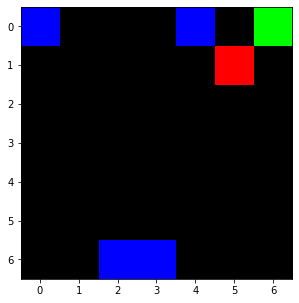

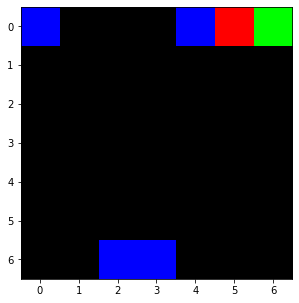

Episode: 11, step: 12, Reward: 1.0, avg loss: 0.000, eps: 0.010


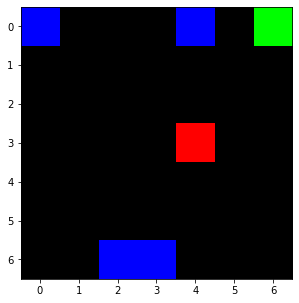

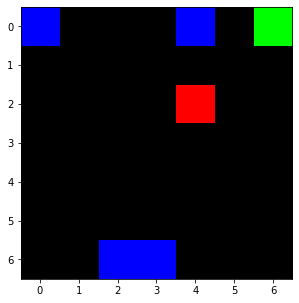

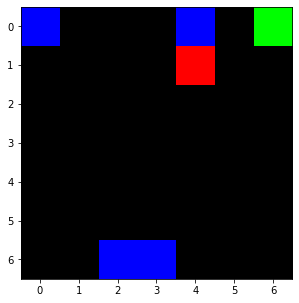

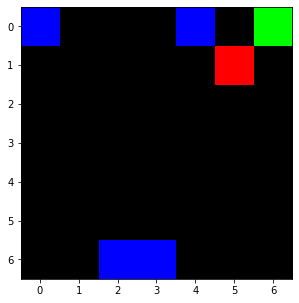

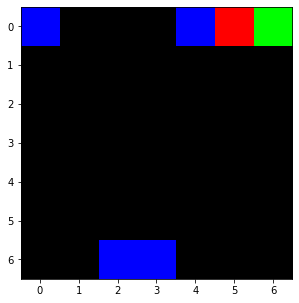

Episode: 12, step: 4, Reward: 1.0, avg loss: 0.000, eps: 0.010


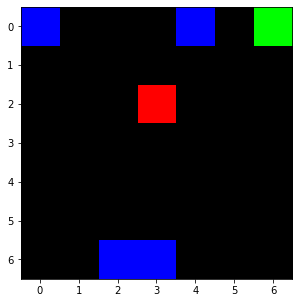

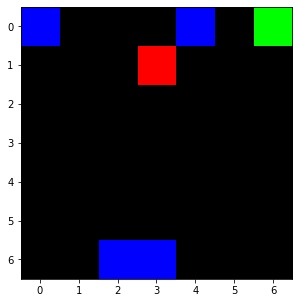

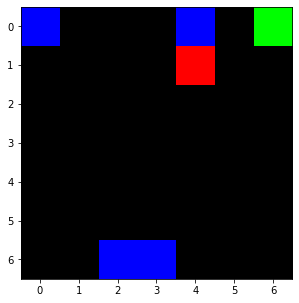

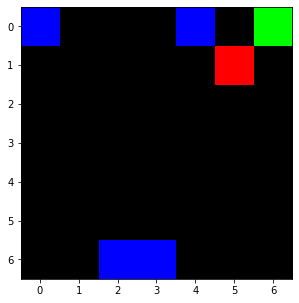

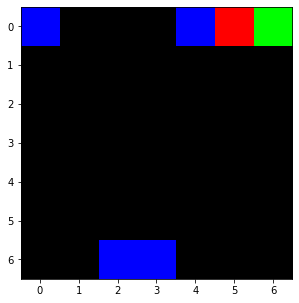

Episode: 13, step: 4, Reward: 1.0, avg loss: 0.000, eps: 0.010


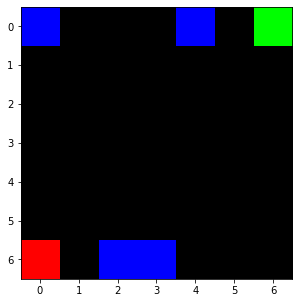

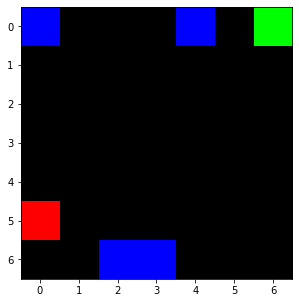

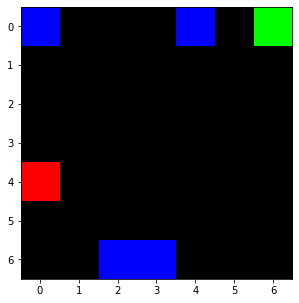

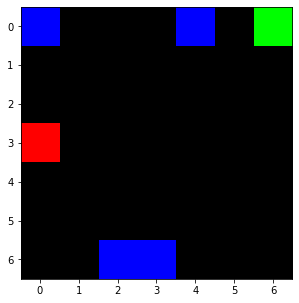

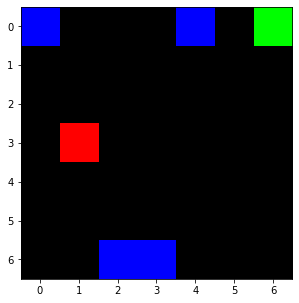

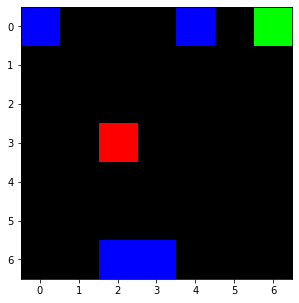

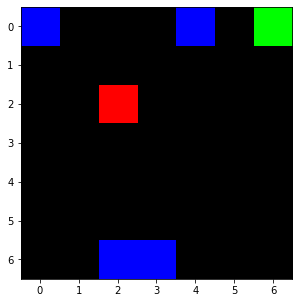

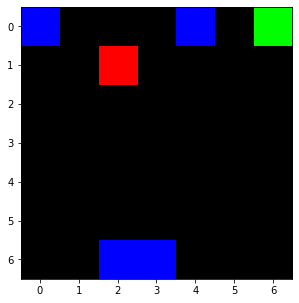

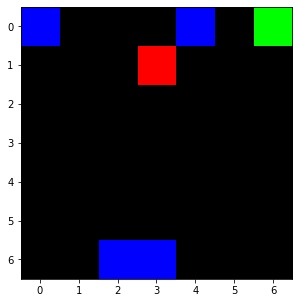

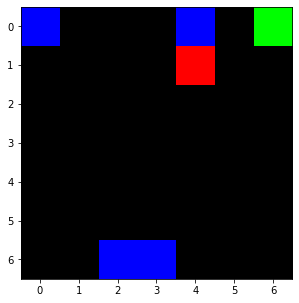

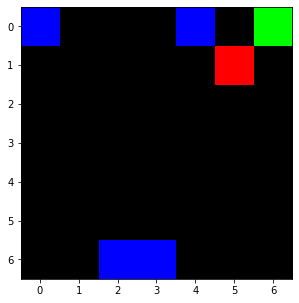

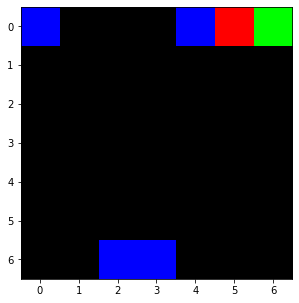

Episode: 14, step: 11, Reward: 1.0, avg loss: 0.000, eps: 0.010
step 11


In [8]:
render = True
steps = 100000 # on simule un step pour avoir un espilon minimum

test_num_episodes = 15

for i in range(test_num_episodes):
    state = env.reset()
    cnt = 0
    avg_loss = 0
    while True:
        if render:
            env.render()
#         action, eps = random.randint(0, env.action_space.n - 1), 0.01
        action, eps = agent.choose_action(state, agent.primary_network, steps)
    
        next_state, reward, done, info = env.step(action)
        
#         reward = np.random.normal(1.0, RANDOM_REWARD_STD)
        if done:
            next_state = None

        state = next_state

        if done:
            if cnt != 0 : avg_loss /= cnt
            else : avg_loss = 0
            print(f"Episode: {i}, step: {cnt}, Reward: {reward_sum}, avg loss: {avg_loss:.3f}, eps: {eps:.3f}")
            with train_writer.as_default():
                tf.summary.scalar('reward', cnt, step=i)
                tf.summary.scalar('avg loss', avg_loss, step=i)
            break

        cnt += 1
print("step", cnt)
env.close()

In [9]:
env.close()